# Installation and Imports

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 31.7 MB/s 
     |████████████████████████████████| 3.5 MB 25.9 MB/s 
     |████████████████████████████████| 407 kB 26.9 MB/s 
     |████████████████████████████████| 41 kB 498 kB/s 


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch_geometric.nn import MessagePassing

In [5]:
MessagePassing??

In [7]:
from torch.nn import Parameter, Module, Sigmoid
import torch
import torch_scatter
import torch.nn.functional as F

class AbstractLAFLayer(Module):
    def __init__(self, **kwargs):
        super(AbstractLAFLayer, self).__init__()
        assert 'units' in kwargs or 'weights' in kwargs
        if 'device' in kwargs.keys():
            self.device = kwargs['device']
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.ngpus = torch.cuda.device_count()
        
        if 'kernel_initializer' in kwargs.keys():
            assert kwargs['kernel_initializer'] in [
                'random_normal',
                'glorot_normal',
                'he_normal',
                'random_uniform',
                'glorot_uniform',
                'he_uniform']
            self.kernel_initializer = kwargs['kernel_initializer']
        else:
            self.kernel_initializer = 'random_normal'

        if 'weights' in kwargs.keys():
            self.weights = Parameter(kwargs['weights'].to(self.device), \
                                     requires_grad=True)
            self.units = self.weights.shape[1]
        else:
            self.units = kwargs['units']
            params = torch.empty(12, self.units, device=self.device)
            if self.kernel_initializer == 'random_normal':
                torch.nn.init.normal_(params)
            elif self.kernel_initializer == 'glorot_normal':
                torch.nn.init.xavier_normal_(params)
            elif self.kernel_initializer == 'he_normal':
                torch.nn.init.kaiming_normal_(params)
            elif self.kernel_initializer == 'random_uniform':
                torch.nn.init.uniform_(params)
            elif self.kernel_initializer == 'glorot_uniform':
                torch.nn.init.xavier_uniform_(params)
            elif self.kernel_initializer == 'he_uniform':
                torch.nn.init.kaiming_uniform_(params)
            self.weights = Parameter(params, \
                                     requires_grad=True)
        e = torch.tensor([1,-1,1,-1], dtype=torch.float32, device=self.device)
        self.e = Parameter(e, requires_grad=False)
        num_idx = torch.tensor([1,1,0,0], dtype=torch.float32, device=self.device).\
                                view(1,1,-1,1)
        self.num_idx = Parameter(num_idx, requires_grad=False)
        den_idx = torch.tensor([0,0,1,1], dtype=torch.float32, device=self.device).\
                                view(1,1,-1,1)
        self.den_idx = Parameter(den_idx, requires_grad=False)
        

class LAFLayer(AbstractLAFLayer):
    def __init__(self, eps=1e-7, **kwargs):
        super(LAFLayer, self).__init__(**kwargs)
        self.eps = eps
    
    def forward(self, data, index, dim=0, **kwargs):
        eps = self.eps
        sup = 1.0 - eps 
        e = self.e

        x = torch.clamp(data, eps, sup)
        x = torch.unsqueeze(x, -1)
        e = e.view(1,1,-1)        

        exps = (1. - e)/2. + x*e 
        exps = torch.unsqueeze(exps, -1)
        exps = torch.pow(exps, torch.relu(self.weights[0:4]))

        scatter = torch_scatter.scatter_add(exps, index.view(-1), dim=dim)
        scatter = torch.clamp(scatter, eps)

        sqrt = torch.pow(scatter, torch.relu(self.weights[4:8]))
        alpha_beta = self.weights[8:12].view(1,1,4,-1)
        terms = sqrt * alpha_beta

        num = torch.sum(terms * self.num_idx, dim=2)
        den = torch.sum(terms * self.den_idx, dim=2)
        
        multiplier = 2.0*torch.clamp(torch.sign(den), min=0.0) - 1.0

        den = torch.where((den < eps) & (den > -eps), multiplier*eps, den)

        res = num / den
        return res

## Principal Neighborhood Aggregation

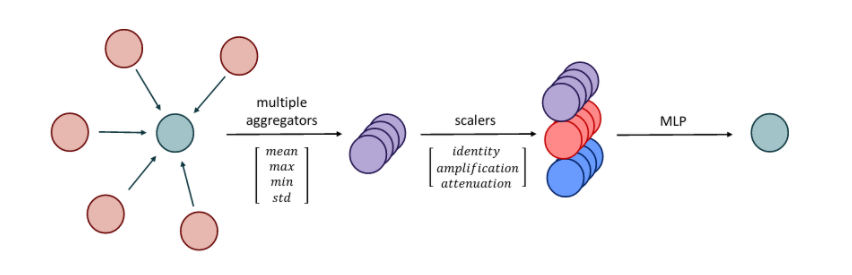

In [11]:
from torch_geometric.nn.conv.gin_conv import GINConv
class GINPNAConv(GINConv):
  def __init__(self, nn, node_dim=32, **kwargs):

    super().__init__(nn, **kwargs)
    self.mlp= torch.nn.Linear(node_dim*12, node_dim)
    self.delta=2.5749

  def aggregate(self, inputs, index):
    sums=torch_scatter.scatter_add(inputs, index, dim=0)
    maxs=torch_scatter.scatter_max(inputs, index, dim=0)[0]
    means=torch_scatter.scatter_mean(inputs, index, dim=0)
    var= torch.relu(torch_scatter.scatter_mean(inputs ** 2, index, dim=0) - means ** 2)

    aggrs= [sums, maxs, means, var]
    c_idx = index.bincount().float().view(-1, 1)    # BinCount calculates the frequency of each value in an array
    l_idx= torch.log(c_idx +1.)

    amplification_scaler= [c_idx / self.delta * a for a in aggrs]
    attenuation_scaler= [self.delta / c_idx * a for a in aggrs]
    combinations= torch.cat(aggrs + amplification_scaler + attenuation_scaler, dim = 1)
    x= self.mlp(combinations)

    return x



In [12]:
def train(epoch):
  model.train()

  if epoch == 50:
    for param_group in optimizer.param_groups:
      param_group['lr'] = 0.5 * param_group['lr']

  loss_all = 0

  for data in train_loader:
    data=data.to(device)
    optimizer.zero_grad()
    output=model(data.x, data.edge_index, data.batch)
    loss=F.nll_loss(output, data.y)
    loss.backward()
    loss_all += loss.item() * data.num_graphs
    optimizer.step()

  return loss_all / len(train_dataset)

In [25]:
def test(loader):
  model.eval()

  correct = 0
  for data in loader:
    data=data.to(device)
    output=model(data.x, data.edge_index, data.batch)
    preds=output.max(dim=1)[1]
    correct += preds.eq(data.y).sum().item()

  return correct / len(loader.dataset)

In [14]:
from torch_geometric.nn import MessagePassing, SAGEConv, GINConv, global_add_pool
import torch_scatter
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import os.path as osp


In [15]:
path = osp.join('./', 'data', 'TU')
dataset = TUDataset(path, name='MUTAG').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

Extracting data/TU/MUTAG/MUTAG.zip
Processing...
Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [16]:
class PNANet(torch.nn.Module):
  def __init__(self):
    super().__init__()

    num_features= dataset.num_features
    dim = 32

    nn1= Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
    self.conv1= GINPNAConv(nn1, node_dim= num_features)
    self.bn1 = torch.nn.BatchNorm1d(dim)

    nn2=Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
    self.conv2= GINPNAConv(nn2, node_dim= dim)
    self.bn2= torch.nn.BatchNorm1d(dim)

    nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
    self.conv3 = GINPNAConv(nn3, node_dim=dim)
    self.bn3 = torch.nn.BatchNorm1d(dim)

    nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
    self.conv4 = GINPNAConv(nn4, node_dim=dim)
    self.bn4 = torch.nn.BatchNorm1d(dim)

    nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
    self.conv5 = GINPNAConv(nn5, node_dim=dim)
    self.bn5 = torch.nn.BatchNorm1d(dim)

    self.fc1 = Linear(dim, dim)
    self.fc2 = Linear(dim, dataset.num_classes)

  def forward(self, x, edge_index, batch):
    x= F.relu(self.conv1(x, edge_index))
    x= self.bn1(x)

    x=F.relu(self.conv2(x, edge_index))
    x=self.bn2(x)

    x=F.relu(self.conv3(x, edge_index))
    x=self.bn3(x)

    x=F.relu(self.conv4(x, edge_index))
    x=self.bn4(x)

    x=F.relu(self.conv5(x, edge_index))
    x=self.bn5(x)

    x= global_add_pool(x,batch)
    x= F.relu(self.fc1(x))

    x= F.dropout(x, p=0.5, training=self.training)
    x=self.fc2(x)

    return F.log_softmax(x, dim= -1)



In [18]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
model=PNANet().to(device)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [28]:

for epoch in range(1, 10):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print('Epoch: {:03d}, Train Loss: {:.7f}, '
          'Train Acc: {:.7f}, Test Acc: {:.7f}'.format(epoch, train_loss,
                                                       train_acc, test_acc))

Epoch: 001, Train Loss: 0.0165145, Train Acc: 0.9941176, Test Acc: 0.8333333
Epoch: 002, Train Loss: 0.0096876, Train Acc: 0.9941176, Test Acc: 0.8333333
Epoch: 003, Train Loss: 0.0115539, Train Acc: 0.9941176, Test Acc: 0.8333333
Epoch: 004, Train Loss: 0.0112785, Train Acc: 1.0000000, Test Acc: 0.8333333
Epoch: 005, Train Loss: 0.0070831, Train Acc: 0.9882353, Test Acc: 0.8333333
Epoch: 006, Train Loss: 0.0174522, Train Acc: 0.9941176, Test Acc: 0.8333333
Epoch: 007, Train Loss: 0.0060754, Train Acc: 0.9941176, Test Acc: 0.8333333
Epoch: 008, Train Loss: 0.0088939, Train Acc: 0.9941176, Test Acc: 0.8333333
Epoch: 009, Train Loss: 0.0070225, Train Acc: 0.9941176, Test Acc: 0.7777778
